In [1]:
GPU_PKG_NAME = "CUDA"; include("common_definitions.jl");

  Activating environment at `~/juliacon21-gpu_workshop/Project.toml`


In [2]:
using ImageFiltering, ColorTypes, FixedPointNumbers, TensorCore
using FileIO, ImageMagick, ImageShow
using BenchmarkTools

using Dagger, DaggerGPU
function dagger_backend()
    if !Dagger.in_thunk()
        return CUDADevice()
    end
    proc = Dagger.thunk_processor()
    if proc isa Dagger.ThreadProc
        return CPU()
    elseif proc isa DaggerGPU.CuArrayDeviceProc
        return CUDADevice()
    else
        return CPU() # fallback
    end
end
cpu_proclist = [Dagger.ThreadProc]
gpu_proclist = [DaggerGPU.CuArrayDeviceProc]

1-element Vector{DataType}:
 CuArrayDeviceProc

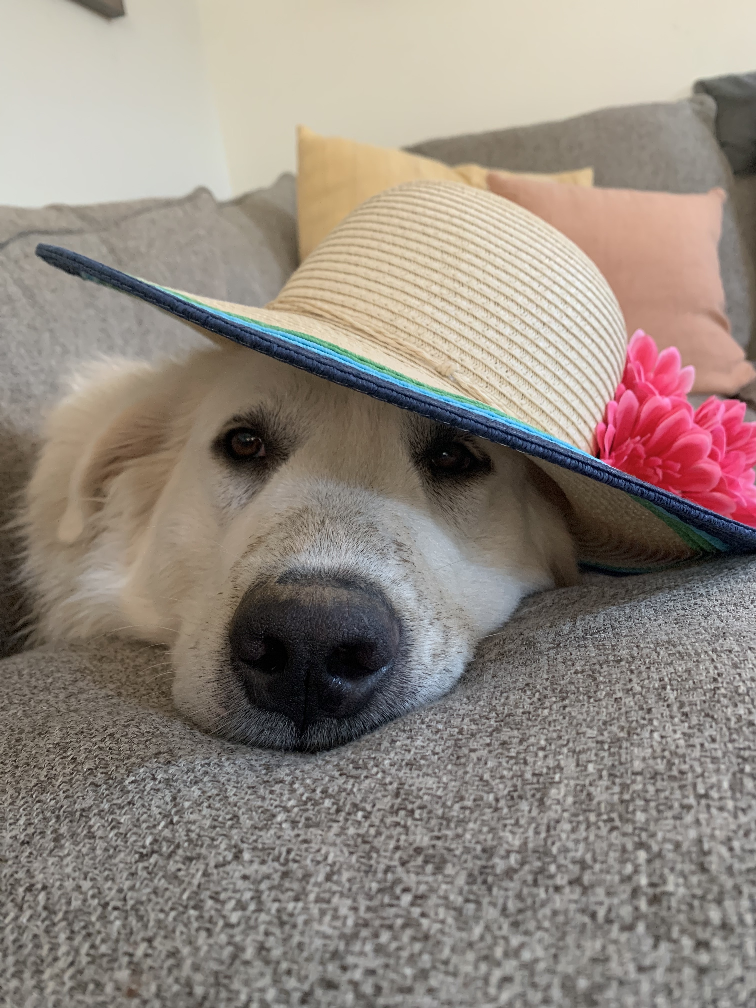

┌ Info: For better quality inline display of large images or thumbnails, load the Images package.
└ @ ImageShow /home/jpsamaroo/.julia/packages/ImageShow/11zF7/src/showmime.jl:131


In [3]:
lilly = FileIO.load("Lilly_hat.jpg")

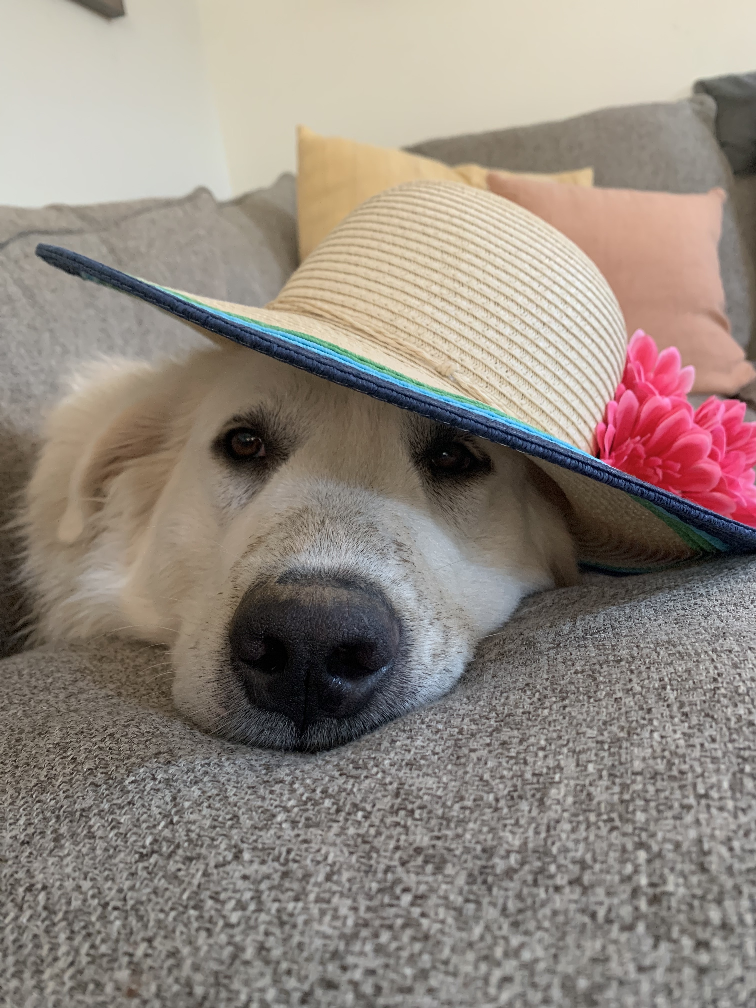

In [4]:
lilly_gpu = GpuArray(map(RGB{Float32}, lilly))
# Let's be careful to not render a GPU array! Scalar indexing is *slow*
Array(lilly_gpu)

Let's do some simple image operations on this image. Let's start with a basic negative:

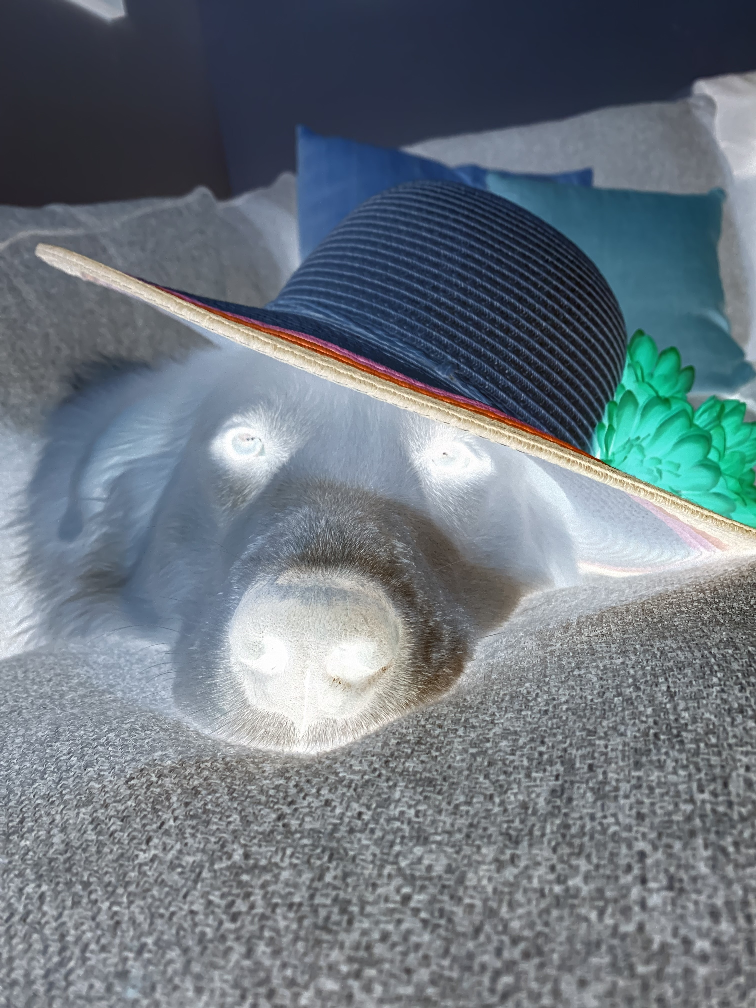

In [5]:
lilly_negative = RGB(1) .- lilly_gpu
Array(lilly_negative)

Cool! We can also adjust the brightness of the image pretty easily:

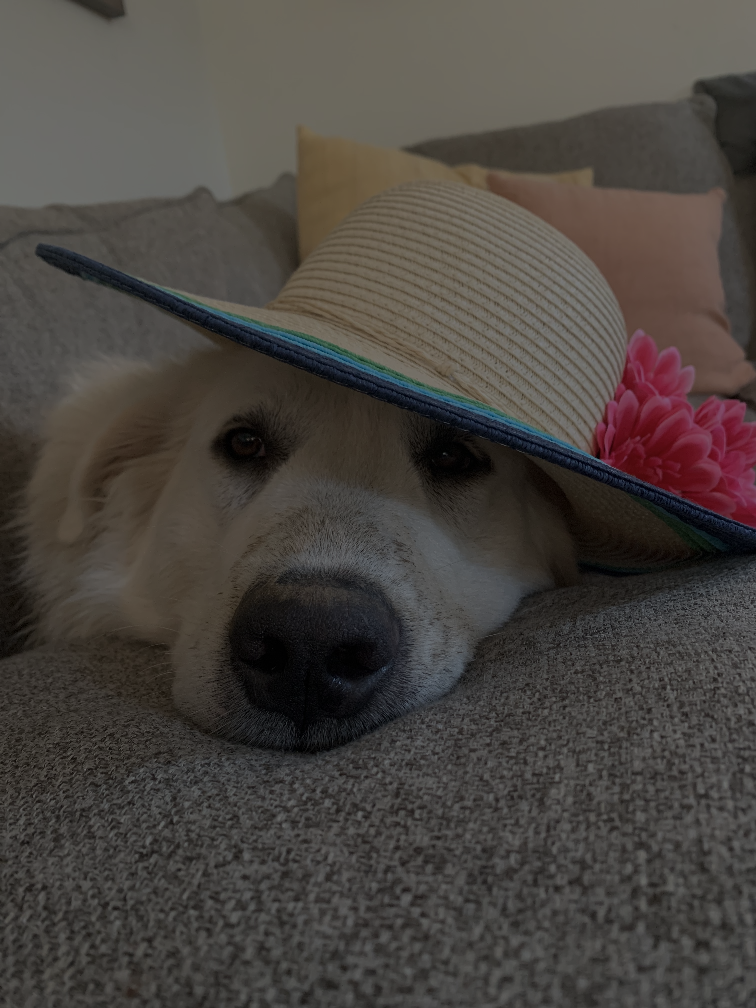

In [6]:
lilly_darker = lilly_gpu .* 0.5
Array(lilly_darker)

Broadcast operations work well for some things, but to get at more complicated operations, we sometimes need to write our operations as GPU kernels directly. Let's implement a basic translation:

In [7]:
@kernel function translate_kernel(out, inp, translation)
    x_idx, y_idx = @index(Global, NTuple)

    x_outidx = x_idx + translation[1]
    y_outidx = y_idx + translation[2]

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

translate_kernel (generic function with 5 methods)

In [8]:
function translate_dagger(lilly_inp)
    lilly_moved = similar(lilly_inp)
    lilly_moved .= RGB(0)
    wait(translate_kernel(dagger_backend())(lilly_moved, lilly_inp, (-500, 500); ndrange=size(lilly_inp), workgroupsize=(32,32)))
    lilly_moved
end

translate_dagger (generic function with 1 method)

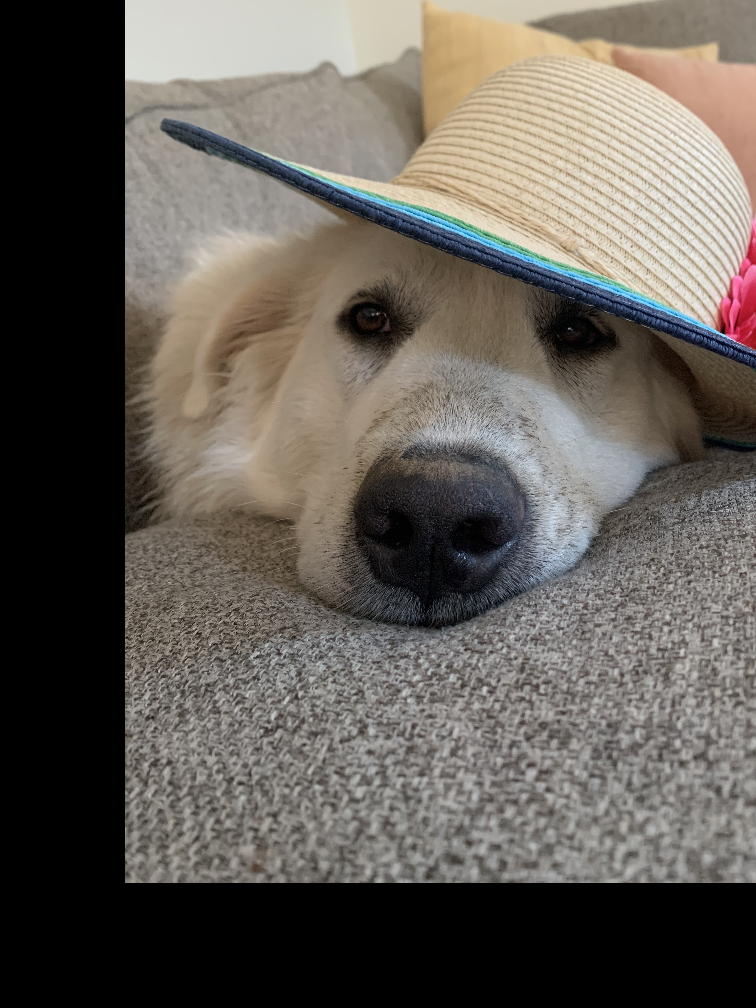

In [9]:
fetch(Dagger.@spawn proclist=gpu_proclist translate_dagger(lilly))

In [10]:
@btime fetch(Dagger.@spawn proclist=cpu_proclist translate_dagger(lilly));

  102.234 ms (985 allocations: 34.93 MiB)


In [26]:
@btime fetch(Dagger.@spawn proclist=gpu_proclist translate_dagger(lilly));

  44.638 ms (1112 allocations: 34.94 MiB)


Great, now let's do a scale operation:

In [27]:
@kernel function scale_kernel(out, inp, scale)
    x_idx, y_idx = @index(Global, NTuple)

    x_outidx = unsafe_trunc(Int, x_idx * scale[1])::Int
    y_outidx = unsafe_trunc(Int, y_idx * scale[2])::Int

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

In [28]:
function scale_dagger(lilly_inp)
    lilly_scaled = similar(lilly_inp)
    lilly_scaled .= RGB(0)
    wait(scale_kernel(dagger_backend())(lilly_scaled, lilly_inp, (0.5, 0.2); ndrange=size(lilly_inp), workgroupsize=(32,32)))
    lilly_scaled
end

scale_dagger (generic function with 1 method)

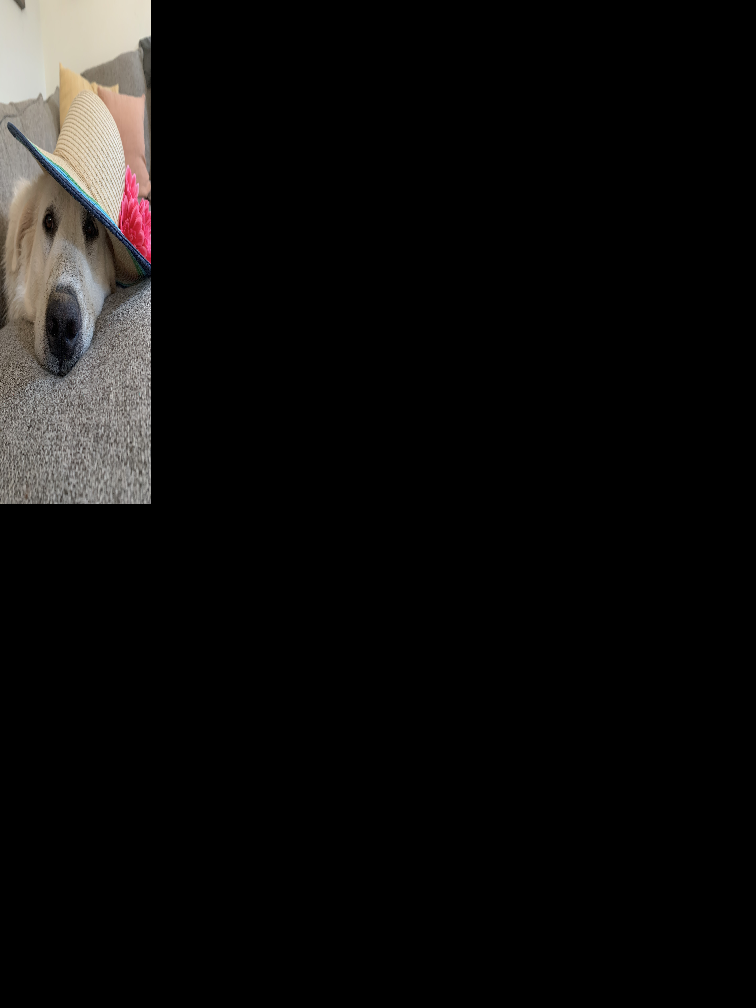

In [29]:
fetch(Dagger.@spawn proclist=gpu_proclist scale_dagger(lilly))

In [30]:
@btime fetch(Dagger.@spawn proclist=cpu_proclist scale_dagger(lilly));

  115.431 ms (1028 allocations: 34.94 MiB)


In [31]:
@btime fetch(Dagger.@spawn proclist=gpu_proclist scale_dagger(lilly));

  44.977 ms (1112 allocations: 34.94 MiB)


Finally, let's rotate this puppy:

In [32]:
@kernel function rotate_kernel(out, inp, angle)
    x_idx, y_idx = @index(Global, NTuple)

    x_centidx = x_idx - (size(inp,1)÷2)
    y_centidx = y_idx - (size(inp,2)÷2)
    x_outidx = unsafe_trunc(Int, (x_centidx*cos(angle)) + (y_centidx*-sin(angle)))::Int
    y_outidx = unsafe_trunc(Int, (x_centidx*sin(angle)) + (y_centidx*cos(angle)))::Int
    x_outidx += (size(inp,1)÷2)
    y_outidx += (size(inp,2)÷2)

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

In [33]:
function rotate_dagger(lilly_inp)
    lilly_rotated = similar(lilly_inp)
    lilly_rotated .= RGB(0)
    wait(rotate_kernel(dagger_backend())(lilly_rotated, lilly_inp, deg2rad(145); ndrange=size(lilly_inp), workgroupsize=(32,32)))
    lilly_rotated
end

rotate_dagger (generic function with 1 method)

In [ ]:
fetch(Dagger.@spawn proclist=gpu_proclist rotate_dagger(lilly))

In [ ]:
@btime fetch(Dagger.@spawn proclist=cpu_proclist rotate_dagger(lilly));

In [ ]:
@btime fetch(Dagger.@spawn proclist=gpu_proclist rotate_dagger(lilly));

Awesome! Those 3 operations are foundational to image processing, and they were easy to implement in Julia! However, there are plenty of other useful operators. How about we implement a Gaussian filter so we can get a blurry puppy?

We can use ImageFiltering to generate the kernels for us on the CPU, and then we just need to massage them into something that'll work on the GPU:

In [22]:
gaussian_k = Kernel.gaussian(15)
gaussian_kG = map(x->RGB{Float32}(Gray(x)), gaussian_k.parent)
gaussian_offsets = abs.(gaussian_k.offsets) .- 1

(30, 30)

And now we need to write out GPU kernel. We're going to implement a correlation (often incorrectly called a convolution) operation, which we can use to apply a filtering kernel to an input image:

In [23]:
@kernel function corr_kernel(out, inp, kern, offsets)
    x_idx, y_idx = @index(Global, NTuple)

    out_T = eltype(out)

    if (1 <= x_idx <= size(out,1)) && (1 <= y_idx <= size(out,2))
        x_toff, y_toff = offsets

        # create our accumulator
        acc = zero(out_T)

        # iterate in column-major order for efficiency
        for y_off in -y_toff:1:y_toff, x_off in -x_toff:1:x_toff
            y_inpidx, x_inpidx = y_idx+y_off, x_idx+x_off
            if (1 <= y_inpidx <= size(inp,2)) && (1 <= x_inpidx <= size(inp,1))
                y_kernidx, x_kernidx = y_off+y_toff+1, x_off+x_toff+1
                acc += hadamard(inp[x_inpidx, y_inpidx],
                                kern[x_kernidx, y_kernidx])
            end
        end
        out[x_idx, y_idx] = acc
    end
end

corr_kernel (generic function with 5 methods)

In [24]:
function corr_dagger(lilly_inp, gaussian_kG, gaussian_offsets)
    @info "Corr start"
    @assert lilly_inp isa CuArray
    @assert gaussian_kG isa CuArray
    lilly_blurry = similar(lilly_inp)
    @assert dagger_backend() isa CUDADevice
    @info "Corr starting"
    wait(corr_kernel(dagger_backend())(lilly_blurry, lilly_inp, gaussian_kG, gaussian_offsets; ndrange=size(lilly_inp), workgroupsize=(32,1)))
    @info "Corr end"
    lilly_blurry
end
fetch(#=Dagger.@spawn proclist=gpu_proclist=# GpuArray(corr_dagger(GpuArray(lilly), GpuArray(gaussian_kG), gaussian_offsets)))

┌ Info: Corr start
└ @ Main In[24]:2
┌ Info: Corr starting
└ @ Main In[24]:7


LoadError: InvalidIRError: compiling kernel gpu_corr_kernel(Cassette.Context{nametype(CUDACtx), Nothing, Nothing, KernelAbstractions.var"##PassType#245", Nothing, Cassette.DisableHooks}, typeof(gpu_corr_kernel), KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{2, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}}}, CuDeviceMatrix{RGB{N0f8}, 1}, CuDeviceMatrix{RGB{N0f8}, 1}, CuDeviceMatrix{RGB{Float32}, 1}, Tuple{Int64, Int64}) resulted in invalid LLVM IR
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
 [2] [0m[1mthrow_inexacterror(::Symbol, ::Type{Int64}, ::UInt64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [4] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mInexactError(::Symbol, ::Type{Int64}, ::UInt64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mthrow_inexacterror(::Symbol, ::Type{Int64}, ::UInt64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [5] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [6] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mthrow_inexacterror(::Symbol, ::Type{Int64}, ::UInt64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
  [3] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mcall[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4mcontext.jl:456[0m
  [2] [0m[1m(::Core.var"[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
  [6] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [9] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [25] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1mrecurse[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:114[0m
  [6] [0m[1m(::Core.var"[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
 [10] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
 [13] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [15] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [17] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [19] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [21] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [23] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [25] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [29] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1mrecurse[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:114[0m
  [6] [0m[1m(::Core.var"[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
 [10] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
 [13] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [15] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [17] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [19] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [21] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [23] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [25] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [29] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mfill!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:406[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:406[0m
  [3] [0m[1mrecurse[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:121[0m
  [4] [0m[1m(::Core.var"[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
  [8] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
 [11] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [13] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [15] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [17] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [19] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [21] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [23] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [27] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:114[0m
  [6] [0m[1mIOBuffer()[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [8] [0m[1mthrow_colorerror_(::Type{N0f8}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:114[0m
  [6] [0m[1mIOBuffer()[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [8] [0m[1mthrow_colorerror_(::Type{N0f8}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mfill!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:406[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:406[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:121[0m
  [4] [0m[1mIOBuffer()[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [6] [0m[1mthrow_colorerror_(::Type{N0f8}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:114[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:115[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:117[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1mwrite(::IOBuffer, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [6] [0m[1mwrite(::IOContext{IOBuffer}, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:700[0m
  [9] [0m[1mprint(::IOContext{IOBuffer}, ::Char)[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [11] [0m[1mshowtype(::IOContext{IOBuffer}, ::Type{N0f8})[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:266[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:266[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [15] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [31] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_excstack_state)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:44[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to an unknown function (call to julia.except_enter)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:44[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1mwrite(::IOBuffer, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [6] [0m[1mwrite(::IOContext{IOBuffer}, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:700[0m
  [9] [0m[1mprint(::IOContext{IOBuffer}, ::Char)[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [15] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [31] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_excstack_state)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:34[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to an unknown function (call to julia.except_enter)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:34[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:680[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [7] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [9] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [16] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [32] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:680[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [7] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [9] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [16] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [32] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:694[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [5] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [7] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [14] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [30] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1munsafe_write(::IOBuffer, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:419[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:419[0m
  [6] [0m[1munsafe_write(::IOContext{IOBuffer}, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:361[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:361[0m
  [8] [0m[1mwrite(::IOContext{IOBuffer}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:185[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:185[0m
 [10] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [17] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [19] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [21] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [23] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [25] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [27] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [29] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [33] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [35] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_pop_handler)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mrethrow()[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:37[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mgetindex(::Tuple{Int64, Char, Int64}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:66[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_pop_handler)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mrethrow()[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:49[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:391[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:391[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mcopy(::Vector{UInt8})[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:349[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:349[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:393[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1104[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:395[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_deleteend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1109[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:395[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:398[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:398[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_copyto!(::Ptr{UInt8}, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:223[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:223[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:167[0m
  [4] [0m[1munsafe_read(::IOBuffer, ::Ptr{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:722[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:722[0m
  [6] [0m[1mread!(::IOBuffer, ::Vector{UInt8})[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:734[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:734[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:399[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [4] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [20] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:114[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:115[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:117[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1mwrite(::IOBuffer, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [6] [0m[1mwrite(::IOContext{IOBuffer}, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:700[0m
  [9] [0m[1mprint(::IOContext{IOBuffer}, ::Char)[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [11] [0m[1mshowtype(::IOContext{IOBuffer}, ::Type{N0f8})[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:266[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:266[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [15] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [31] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_excstack_state)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:44[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to an unknown function (call to julia.except_enter)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:44[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1mwrite(::IOBuffer, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [6] [0m[1mwrite(::IOContext{IOBuffer}, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:700[0m
  [9] [0m[1mprint(::IOContext{IOBuffer}, ::Char)[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [15] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [31] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_excstack_state)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:34[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to an unknown function (call to julia.except_enter)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:34[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:680[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [7] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [9] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [16] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [32] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:680[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [7] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [9] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [16] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [32] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:694[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [5] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [7] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [14] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [30] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1munsafe_write(::IOBuffer, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:419[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:419[0m
  [6] [0m[1munsafe_write(::IOContext{IOBuffer}, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:361[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:361[0m
  [8] [0m[1mwrite(::IOContext{IOBuffer}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:185[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:185[0m
 [10] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [17] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [19] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [21] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [23] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [25] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [27] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [29] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [33] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [35] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_pop_handler)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mrethrow()[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:37[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mgetindex(::Tuple{Int64, Char, Int64}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:66[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_pop_handler)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mrethrow()[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:49[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:391[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:391[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mcopy(::Vector{UInt8})[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:349[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:349[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:393[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1104[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:395[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_deleteend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1109[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:395[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:398[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:398[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_copyto!(::Ptr{UInt8}, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:223[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:223[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:167[0m
  [4] [0m[1munsafe_read(::IOBuffer, ::Ptr{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:722[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:722[0m
  [6] [0m[1mread!(::IOBuffer, ::Vector{UInt8})[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:734[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:734[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:399[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [4] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [20] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:130[0m
  [2] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mgetindex(::Tuple{String, DataType, String, String, String, Int64, String, String, String, String, String, Tuple{Float32, Float32, Float32}, String}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:66[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:130[0m
  [5] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:135[0m
  [2] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mgetindex(::Tuple{String, DataType, String, String, String, Int64, String, String, String, String, String, Tuple{Float32, Float32, Float32}, String}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:66[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:135[0m
  [5] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1104[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:137[0m
  [5] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_deleteend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1109[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:137[0m
  [5] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:137[0m
  [4] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:113[0m
  [6] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:113[0m
  [6] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:113[0m
  [6] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:113[0m
  [6] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
 [2] [0m[1mthrow_inexacterror(::Symbol, ::Type{UInt64}, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [4] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mInexactError(::Symbol, ::Type{UInt64}, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mthrow_inexacterror(::Symbol, ::Type{UInt64}, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [5] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [6] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mthrow_inexacterror(::Symbol, ::Type{UInt64}, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4marray.jl:271[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4marray.jl:313[0m
 [3] [0m[1mcopyto!(::Vector{UInt8}, ::Int64, ::Vector{UInt8}, ::Int64, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4marray.jl:304[0m
 [4] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4marray.jl:304[0m
 [5] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4miobuffer.jl:295[0m
 [6] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4miobuffer.jl:315[0m
 [7] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m

There are plenty of interesting features in this image. Let's use a Sobel filter to see what the edges in the image look like. Note that a Sobel filtering operation actually uses two filter kernels, but we can get a good idea with just one of them.

In [25]:
sobel_k = Kernel.sobel()
sobel_kG = map(RGB{Float32}, sobel_k[1].parent)
sobel_offsets = abs.(sobel_k[1].offsets) .- 1

function sobel_dagger(lilly_inp, sobel_kG, sobel_offsets)
    @assert lilly_inp isa CuArray
    @assert sobel_kG isa CuArray
    lilly_sobel = similar(lilly_inp)
    wait(corr_kernel(dagger_backend())(lilly_sobel, lilly_inp, sobel_kG, sobel_offsets; ndrange=size(lilly_inp), workgroupsize=(32,1)))
    lilly_sobel
end
lilly_sobel = fetch(#=Dagger.@spawn proclist=gpu_proclist=# GpuArray(sobel_dagger(GpuArray(lilly), GpuArray(sobel_kG), sobel_offsets)))
# Post-process the Sobel gradients into something comprehendable by humans
map(x->mapc(y->y > 0 ? 1.0 : 0.0, x), lilly_sobel)

LoadError: InvalidIRError: compiling kernel gpu_corr_kernel(Cassette.Context{nametype(CUDACtx), Nothing, Nothing, KernelAbstractions.var"##PassType#245", Nothing, Cassette.DisableHooks}, typeof(gpu_corr_kernel), KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{2, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}}}, CuDeviceMatrix{RGB{N0f8}, 1}, CuDeviceMatrix{RGB{N0f8}, 1}, CuDeviceMatrix{RGB{Float32}, 1}, Tuple{Int64, Int64}) resulted in invalid LLVM IR
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
 [2] [0m[1mthrow_inexacterror(::Symbol, ::Type{Int64}, ::UInt64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [4] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mInexactError(::Symbol, ::Type{Int64}, ::UInt64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mthrow_inexacterror(::Symbol, ::Type{Int64}, ::UInt64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [5] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [6] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mthrow_inexacterror(::Symbol, ::Type{Int64}, ::UInt64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
  [3] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mcall[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4mcontext.jl:456[0m
  [2] [0m[1m(::Core.var"[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
  [6] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [9] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [25] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1mrecurse[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:114[0m
  [6] [0m[1m(::Core.var"[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
 [10] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
 [13] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [15] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [17] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [19] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [21] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [23] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [25] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [29] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1mrecurse[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:114[0m
  [6] [0m[1m(::Core.var"[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
 [10] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
 [13] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [15] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [17] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [19] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [21] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [23] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [25] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [29] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mfill!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:406[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:406[0m
  [3] [0m[1mrecurse[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:121[0m
  [4] [0m[1m(::Core.var"[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:133[0m
  [8] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
 [11] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [13] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [15] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [17] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [19] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [21] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [23] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [27] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:114[0m
  [6] [0m[1mIOBuffer()[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [8] [0m[1mthrow_colorerror_(::Type{N0f8}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:114[0m
  [6] [0m[1mIOBuffer()[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [8] [0m[1mthrow_colorerror_(::Type{N0f8}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mfill!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:406[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:406[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:121[0m
  [4] [0m[1mIOBuffer()[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:112[0m
  [6] [0m[1mthrow_colorerror_(::Type{N0f8}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:682[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:114[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:115[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:117[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1mwrite(::IOBuffer, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [6] [0m[1mwrite(::IOContext{IOBuffer}, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:700[0m
  [9] [0m[1mprint(::IOContext{IOBuffer}, ::Char)[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [11] [0m[1mshowtype(::IOContext{IOBuffer}, ::Type{N0f8})[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:266[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:266[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [15] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [31] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_excstack_state)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:44[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to an unknown function (call to julia.except_enter)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:44[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1mwrite(::IOBuffer, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [6] [0m[1mwrite(::IOContext{IOBuffer}, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:700[0m
  [9] [0m[1mprint(::IOContext{IOBuffer}, ::Char)[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [15] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [31] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_excstack_state)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:34[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to an unknown function (call to julia.except_enter)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:34[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:680[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [7] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [9] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [16] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [32] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:680[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [7] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [9] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [16] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [32] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:694[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [5] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [7] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [14] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [30] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1munsafe_write(::IOBuffer, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:419[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:419[0m
  [6] [0m[1munsafe_write(::IOContext{IOBuffer}, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:361[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:361[0m
  [8] [0m[1mwrite(::IOContext{IOBuffer}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:185[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:185[0m
 [10] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [17] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [19] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [21] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [23] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [25] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [27] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [29] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [33] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [35] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_pop_handler)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mrethrow()[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:37[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mgetindex(::Tuple{Int64, Char, Int64}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:66[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_pop_handler)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mrethrow()[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:49[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:391[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:391[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mcopy(::Vector{UInt8})[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:349[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:349[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:393[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1104[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:395[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_deleteend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1109[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:395[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:398[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:398[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_copyto!(::Ptr{UInt8}, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:223[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:223[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:167[0m
  [4] [0m[1munsafe_read(::IOBuffer, ::Ptr{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:722[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:722[0m
  [6] [0m[1mread!(::IOBuffer, ::Vector{UInt8})[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:734[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:734[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:399[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
  [4] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [20] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:114[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:115[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:117[0m
  [2] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1mwrite(::IOBuffer, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [6] [0m[1mwrite(::IOContext{IOBuffer}, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:700[0m
  [9] [0m[1mprint(::IOContext{IOBuffer}, ::Char)[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [11] [0m[1mshowtype(::IOContext{IOBuffer}, ::Type{N0f8})[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:266[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:266[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [15] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [31] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_excstack_state)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:44[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to an unknown function (call to julia.except_enter)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:44[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1mwrite(::IOBuffer, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:446[0m
  [6] [0m[1mwrite(::IOContext{IOBuffer}, ::UInt8)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:360[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:700[0m
  [9] [0m[1mprint(::IOContext{IOBuffer}, ::Char)[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mchar.jl:229[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [15] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [31] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_excstack_state)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:34[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to an unknown function (call to julia.except_enter)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:34[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:680[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [7] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [9] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [16] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [32] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:680[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [7] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [9] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [16] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [32] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [33] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:694[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:770[0m
  [5] [0m[1mstring(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mintfuncs.jl:761[0m
  [7] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [14] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [16] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [18] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [20] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [22] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [24] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [26] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [29] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [30] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:330[0m
  [4] [0m[1munsafe_write(::IOBuffer, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:419[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:419[0m
  [6] [0m[1munsafe_write(::IOContext{IOBuffer}, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:361[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:361[0m
  [8] [0m[1mwrite(::IOContext{IOBuffer}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:185[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:185[0m
 [10] [0m[1mshow(::IOContext{IOBuffer}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mshow.jl:919[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [17] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [19] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [21] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [23] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [25] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [27] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [29] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [30] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [31] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [32] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [33] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [34] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [35] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_pop_handler)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:35[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mrethrow()[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:37[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mgetindex(::Tuple{Int64, Char, Int64}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:66[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_pop_handler)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:46[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mrethrow()[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4merror.jl:59[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:49[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:269[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:275[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:391[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:391[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mcopy(::Vector{UInt8})[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:349[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:349[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:393[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1104[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:395[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_deleteend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1109[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:395[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [6] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [22] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:398[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:398[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_copyto!(::Ptr{UInt8}, ::Ptr{UInt8}, ::UInt64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:223[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:223[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:167[0m
  [4] [0m[1munsafe_read(::IOBuffer, ::Ptr{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:722[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:722[0m
  [6] [0m[1mread!(::IOBuffer, ::Vector{UInt8})[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:734[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mio.jl:734[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:399[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
  [4] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [20] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:130[0m
  [2] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mgetindex(::Tuple{String, DataType, String, String, String, Int64, String, String, String, String, String, Tuple{Float32, Float32, Float32}, String}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:66[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:130[0m
  [5] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported dynamic function invocation (call to overdub)
Stacktrace:
  [1] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:135[0m
  [2] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [5] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [7] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
  [9] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [11] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [13] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [15] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [17] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [21] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
  [1] [0m[1mgetindex(::Tuple{String, DataType, String, String, String, Int64, String, String, String, String, String, Tuple{Float32, Float32, Float32}, String}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:29[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mtuple.jl:66[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:135[0m
  [5] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_growend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:884[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1104[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:137[0m
  [5] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_deleteend!(::Vector{UInt8}, ::Int64)[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:893[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4marray.jl:1109[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:137[0m
  [5] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [8] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [10] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [12] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [14] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [16] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [18] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [20] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [24] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [26] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1mString(::Vector{UInt8})[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:53[0m
  [3] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:137[0m
  [4] [0m[1mstring(::String, ::Type{N0f8}, ::String, ::String, ::String, ::Int64, ::String, ::String, ::String, ::String, ::String, ::Tuple{Float32, Float32, Float32}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mio.jl:174[0m
  [6] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:686[0m
  [7] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
  [9] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [10] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [11] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [12] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [13] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [14] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [15] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [16] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [17] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [18] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [19] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [20] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [22] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [23] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:113[0m
  [6] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:113[0m
  [6] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:683[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1m_string_n(::Int64)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:74[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:113[0m
  [6] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
  [1] [0m[1munsafe_wrap(::Type{Vector{UInt8}}, ::String)[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [2] [0m[1moverdub[22m
[90m    @ [39m[90m./strings/[39m[90;4mstring.jl:85[0m
  [3] [0m[1mStringVector(::Int64)[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [4] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4miobuffer.jl:31[0m
  [5] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:113[0m
  [6] [0m[1mshow(::IOContext{IOBuffer}, ::Float64)[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [7] [0m[1moverdub[22m
[90m    @ [39m[90m./ryu/[39m[90;4mRyu.jl:112[0m
  [8] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/FixedPointNumbers/HAGk2/src/[39m[90;4mFixedPointNumbers.jl:274[0m
  [9] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:684[0m
 [10] [0m[1mthrow_colorerror(::Type{RGB{N0f8}}, ::Tuple{Float32, Float32, Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [11] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:736[0m
 [12] [0m[1mcheckval(::Type{RGB{N0f8}}, ::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [13] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:654[0m
 [14] [0m[1mRGB{N0f8}(::Float32, ::Float32, ::Float32)[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [15] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mtypes.jl:101[0m
 [16] [0m[1m_convert(::Type{RGB{N0f8}}, ::Type{RGB}, ::Type{RGB}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [17] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:87[0m
 [18] [0m[1mcconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [19] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:76[0m
 [20] [0m[1mconvert(::Type{RGB{N0f8}}, ::RGB{Float32})[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [21] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/ColorTypes/6m8P7/src/[39m[90;4mconversions.jl:73[0m
 [22] [0m[1msetindex!(::CuDeviceMatrix{RGB{N0f8}, 1}, ::RGB{Float32}, ::Int64)[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [23] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/CUDA/lwSps/src/device/[39m[90;4marray.jl:192[0m
 [24] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1284[0m
 [25] [0m[1moverdub[22m
[90m    @ [39m[90m./[39m[90;4mabstractarray.jl:1261[0m
 [26] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90;4mIn[23]:21[0m
 [27] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/KernelAbstractions/8W8KX/src/[39m[90;4mmacros.jl:80[0m
 [28] [0m[1moverdub[22m
[90m    @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
 [2] [0m[1mthrow_inexacterror(::Symbol, ::Type{UInt64}, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [4] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [5] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mInexactError(::Symbol, ::Type{UInt64}, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mthrow_inexacterror(::Symbol, ::Type{UInt64}, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [5] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [6] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [7] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mthrow_inexacterror(::Symbol, ::Type{UInt64}, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:602[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call through a literal pointer (call to )
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4marray.jl:271[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4marray.jl:313[0m
 [3] [0m[1mcopyto!(::Vector{UInt8}, ::Int64, ::Vector{UInt8}, ::Int64, ::Int64)[22m
[90m   @ [39m[90m./[39m[90;4marray.jl:304[0m
 [4] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4marray.jl:304[0m
 [5] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4miobuffer.jl:295[0m
 [6] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4miobuffer.jl:315[0m
 [7] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [8] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m